In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pywarper import Warper


In [2]:
def read_chat(fname: str) -> dict[str, np.ndarray]:
    """Read a ChAT‐band point cloud exported by KNOSSOS/FiJi.

    Parameters
    ----------
    fname
        Plain‐text file with at least the columns *X*, *Y*, *Slice* as in the
        Sümbül *et al.* (2014) dataset.

    Returns
    -------
    dict
        With keys ``x``, ``y``, ``z`` (1‑based index, *float64*).
    """
    df = pd.read_csv(fname, comment="#", sep=r"\s+")

    # KNOSSOS axes → (x, y, z) in µm; +1 to mimic MATLAB 1‑based convention
    return {
        "x": df["X"].to_numpy(float) + 1,
        "y": df["Slice"].to_numpy(float),
        "z": df["Y"].to_numpy(float) + 1,
    }

# data from Sümbül et al. 2014
# https://github.com/uygarsumbul/rgc
chat_top = read_chat("../tests/data/Image013-009_01_ChAT-TopBand-Mike.txt") # should be the off sac layer
chat_bottom = read_chat("../tests/data/Image013-009_01_ChAT-BottomBand-Mike.txt") # should be the on sac layer
# but the image can be flipped
if chat_top["z"].mean() > chat_bottom["z"].mean():
    off_sac = chat_top
    on_sac = chat_bottom
else:
    off_sac = chat_bottom
    on_sac = chat_top

In [3]:
cell_path = "../tests/data/Image013-009_01_raw_latest_Uygar.swc"
w = Warper(off_sac, on_sac, cell_path, voxel_resolution=[0.4, 0.4, 0.5], verbose=True)
w.nodes += 1  # to match the matlab behavior

[pywarper] Loading arbor → ../tests/data/Image013-009_01_raw_latest_Uygar.swc


In [4]:
w.fit_surfaces()

[pywarper] Fitting OFF‑SAC surface …
[pywarper] Fitting ON‑SAC surface …


In [5]:
w.build_mapping()

[pywarper] Building mapping …
Mapping ON (min) surface …
Completed in 0.82 seconds.
Mapping OFF (max) surface …
Completed in 0.76 seconds.


In [6]:
# warp the arbor
w.warp_arbor()

[pywarper] Warping arbor …
Warping nodes...
Nodes warped in 1.25 seconds.


In [11]:
w.get_arbor_denstiy(
    z_res=0.5, z_window=[-30, 30], z_nbins=120,
    xy_window=[50, 250, 50, 250], xy_nbins=20,
)

In [12]:
# import skeliner as sk

# sk.plot2d(w.warped_arbor['skel'], plane="xz", unit="µm")

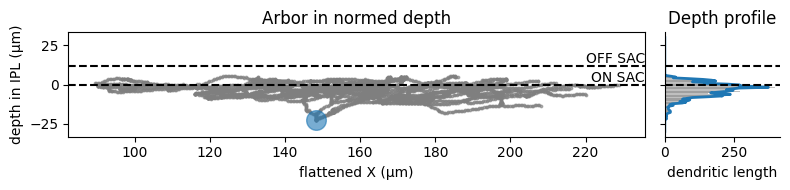

In [13]:
fig, (ax_nodes, ax_prof) = plt.subplots(
    1, 2,
    figsize=(8, 2),
    sharey=True,                 # align the y-axes
    gridspec_kw={'width_ratios': [5, 1]}
)

# --- left: flattened arbor ----------------------------------------
ax_nodes.scatter(
    w.normed_arbor["nodes"][:, 0],   # flattened X in µm
    w.normed_arbor["nodes"][:, 2],   # depth (0…12 µm)
    s=3,  c='tab:gray', alpha=0.6
)
ax_nodes.set_xlabel('flattened X (µm)')
ax_nodes.set_ylabel('depth in IPL (µm)')
ax_nodes.set_title('Arbor in normed depth')

# guide lines at ON / OFF SAC
for y in (0, 12):
    ax_nodes.axhline(y, ls='--', c='k')
ax_nodes.text(ax_nodes.get_xlim()[1], 0,
              'ON SAC', va='bottom', ha='right', fontsize=10)
ax_nodes.text(ax_nodes.get_xlim()[1], 12,
              'OFF SAC', va='bottom', ha='right', fontsize=10)

ax_nodes.scatter(
    w.normed_arbor["nodes"][0, 0],   
    w.normed_arbor["nodes"][0, 2],  
    s=200,  c='tab:blue', alpha=0.6
)

# --- right: depth profile (horizontal) ----------------------------
ax_prof.plot(w.z_dist, w.z_x, lw=2, c='tab:blue')
ax_prof.barh(w.z_x, w.z_hist, color="gray", alpha=0.5)
ax_prof.set_xlabel('dendritic length')
ax_prof.set_title('Depth profile')
ax_prof.axhline(0,  ls='--', c='k')
ax_prof.axhline(12, ls='--', c='k')

# remove unneeded spines to tidy the small panel
ax_prof.spines['top'].set_visible(False)
ax_prof.spines['right'].set_visible(False)

fig.tight_layout()
plt.show()

In [ ]:
from pywarper.stats import get_convex_hull, get_hull_centroid, get_xy_center_of_mass

hull = get_convex_hull(w.normed_arbor['nodes'][:, 0:2])
com_hull = get_hull_centroid(hull)

com_xy = get_xy_center_of_mass(w.xy_x, w.xy_y, w.xy_dist)

KeyError: 'edges'

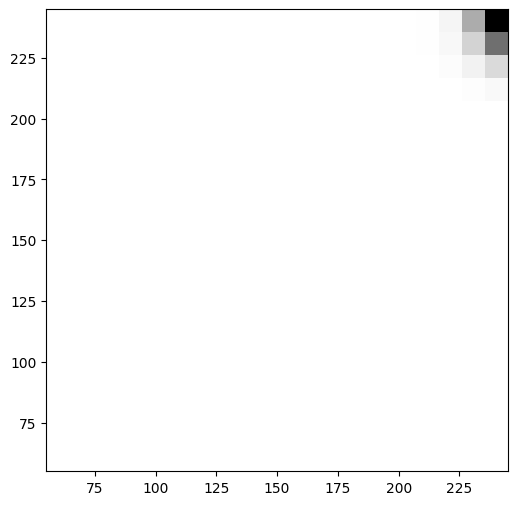

In [ ]:
from matplotlib.colors import Normalize
fig, ax = plt.subplots(figsize=(6, 6))

im = ax.imshow(
    w.xy_dist.T, origin="lower",
    extent=[w.xy_x[0], w.xy_x[-1], w.xy_y[0], w.xy_y[-1]],
    cmap="Greys", norm=Normalize(vmin=0, vmax=w.xy_dist.max()),
)

for c, p in w.warped_arbor["edges"]:
    if p == -1:          # skip soma parent
        continue
    ax.plot(
        [w.warped_arbor["nodes"][c-1, 0], w.warped_arbor["nodes"][p-1, 0]],
        [w.warped_arbor["nodes"][c-1, 1], w.warped_arbor["nodes"][p-1, 1]],
        lw=1, color='red',
    )

ax.scatter(
    w.warped_arbor["nodes"][0, 0],
    w.warped_arbor["nodes"][0, 1],
    s=100, color='blue', zorder=99, label='soma',
)

ax.scatter(
    com_hull[0], com_hull[1],
    s=100, color='orange', zorder=99, label='hull centroid'
)

ax.scatter(
    com_xy[0], com_xy[1],
    s=100, color='pink', zorder=99, label='arbor center'
)

plt.fill(hull[:, 0], hull[:, 1], facecolor="none", edgecolor="orange", linewidth=1)

ax.legend(frameon=False)

In [ ]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-05-20 09:27:43CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

matplotlib: 3.10.1
numpy     : 2.2.4
pandas    : 2.2.3
pywarper  : 0.1.5

Watermark: 2.5.0

